In [ ]:
# OVERVIEW OF WHAT I HAVE TRIED

# 1) 4 FE Sets --> 
    # 1) OHE 
    # 2) k-FOLD TARGET-ENCODING 
    # 3) BINARY ENCODING(for nominal variables) + LABEL ENCODING (for ordinal variabels)
    # 4) k-FOLD TARGET-ENCODING(for nominal variables with high cardinality) + OHE(for nominal variables with low cardinality) + Label Encoding(for ordinal variabels)   (by logic)

# 2) Creation of a Baseline model i.e. Logistic Regression with the first FE set (OHE) ; This will tell us whether our solution implementation is sensible or not

# 3) we'll create a function which will try all simple models(KNN,DT,LR,NB) on each feature-encoded data and print out the results in a HIGHLIGHTED-TABLE

# 4) Take the best simple model and tune it. This will prove the baseline for our advanced models. Tune it on all 4 feature sets and select the one with best accuracy.

# 5) Try each Advanced models separately with tuning.
    # 1) Random forest model on all sets except set-1 encoded sets (SET-1 has d>100)
    # 2) SVM Kernelized on all sets 
    # 3) XGBoost model on all sets except set-1 encoded sets

# 6) Try Relief-F feature selection with XGBoost for perf improvement.

# 7) Compare best one with CATBOOST (remember to send raw data to catboost without any encoding)

# 8) The model chosen from above step will be final. Now try feature expansion by adding clustering-labels for perf improvement.

# 8) Done!

#### Imports and loading data

In [2]:

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy
%matplotlib inline

from collections import defaultdict
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost


# Reference :-  https://contrib.scikit-learn.org/category_encoders/
!pip install category_encoders 
!pip install skrebate
!pip install catboost
!pip install kmodes
import category_encoders as ce
from skrebate import ReliefF
from catboost import CatBoostClassifier
from kmodes.kmodes import KModes
from tqdm import tqdm
import pickle

     |████████████████████████████████| 82 kB 422 kB/s 
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29271 sha256=f4d64d69b718d81641988a6efdb3938fba627fd0229bcaeb2af8d1554f86610b
  Stored in directory: /root/.cache/pip/wheels/4f/3b/07/22a9a01f3f25cd376122b5ef526737a44993b4c312e50916ed
Successfully built skrebate
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Datasets and utils/Preprocessed_data.csv')

In [50]:
df.drop('car',axis=1,inplace=True)
df.head(3)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_opp,Y,driving_distance
0,No Urgent Place,Alone,Sunny,Low,Evening,Restaurant(<20),24h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1 to 3,4 to 8,1 to 3,1,1,within 5mins
1,No Urgent Place,Friend(s),Sunny,High,Morning,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1 to 3,4 to 8,1 to 3,1,0,within 5mins
2,No Urgent Place,Friend(s),Sunny,High,Morning,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,never,never,1 to 3,4 to 8,1 to 3,1,1,within 15mins


In [51]:
y = df[['Y']]
df.drop('Y',inplace=True,axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42,stratify=y)

# to avoid confusion/errors , let's reset index
for ele in [X_train, X_test, y_train, y_test]:
    ele.reset_index(inplace=True,drop=True)

#### Feature Engineering

We'll create 4 feature encoded sets 

One Hot Encoding

In [ ]:
def OHE(train_data,test_data,cat_cols=None):
    ''' OHE encode the data '''
    if not cat_cols:
        cat_cols = train_data.dtypes[train_data.dtypes==object].index.values
    num_cols = list(set(train_data.columns) - set(cat_cols))

    enc = OneHotEncoder(handle_unknown='ignore')
    train_ohe = enc.fit_transform(train_data[cat_cols]).toarray()
    
    columns = list(enc.get_feature_names_out(cat_cols)) + num_cols
    train_ohe = np.hstack((train_ohe,train_data[num_cols].values))  # stack transformed_cat_cols with num_cols
    train_ohe = pd.DataFrame(train_ohe,columns=columns)

    test_ohe = enc.transform(test_data[cat_cols]).toarray()
    test_ohe = np.hstack((test_ohe,test_data[num_cols].values))
    test_ohe = pd.DataFrame(test_ohe,columns=columns)

    return train_ohe,test_ohe

In [ ]:
train_set1,test_set1 = OHE(X_train,X_test)


K-fold Target Encoding

In [ ]:
# Reference :- https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b
# The code is my own but the idea/logic is copied

def k_fold(train_data,test_data,train_target,cat_cols=None,k=5,impute_test_with_kFold_data=False):
    ''' K-fold target/mean encode the data
    In train we'll perform k-fold target encoding
    In test we'll just encode with the mean of the target-variable of train
    
    K-fold encoding is not performed on 2 numeric columns --> has_children and direction_opposite
    A very important thing to note is that we'll be making changes to the dataframe itself so it's important to make copy of it first 
    '''

    mean_of_target = train_target.mean()
    if not cat_cols:
        cat_cols = train_data.dtypes[train_data.dtypes==object].index.values

    test_mapper = {}  # to store imputation values for use in productionization
    kf = KFold(n_splits=k, shuffle=False)

    #  let's concat the variables and target together as we'll need both for imputing. Also we want a copy of train data to target-encode.
    train_data = pd.concat([train_data,train_target],axis=1)
    train_data_copy_to_impute_in = train_data.copy()
    test_data_copy_to_impute_in = test_data.copy()

    for ele in kf.split(train_data):
        train_indices,hold_out_indices = ele

        cv_train = train_data.iloc[train_indices]
        cv_val = train_data.iloc[hold_out_indices]

        for col in cat_cols:
            train_data_copy_to_impute_in.loc[train_data.index[hold_out_indices],col] = cv_val[col].map(cv_train.groupby(col).Y.mean())
            
        #  Edge case :- For each column, there might exist a fold which has some categories which aren't present in any other folds, which results in NAN's. 
        # Instead we will impute it with global mean of target. 
        train_data_copy_to_impute_in[cat_cols].fillna(mean_of_target,inplace=True) 

    
    # store mean values from full train-data (k-fold encoded one) for test-data imputations
    
    if impute_test_with_kFold_data:
        for col in cat_cols:
            unique_cats = train_data[col].unique()
            for category in unique_cats:
                value = train_data_copy_to_impute_in[train_data[col]==category][col].mean()
                test_data_copy_to_impute_in.loc[test_data_copy_to_impute_in[col]==category,col] = value  # making changes in test data copy
                test_mapper.update({(col,category):value})

    else: # store mean values from full train-data for test-data imputations
        for col in cat_cols:
            s = train_data.groupby(col).Y.mean()
            for category,value in s.items():
                test_data_copy_to_impute_in.loc[test_data_copy_to_impute_in[col]==category,col] = value  # making changes in test data copy
                test_mapper.update({(col,category):value})

    train_data_copy_to_impute_in.drop('Y',axis=1,inplace=True)    # we should drop target before returning

    return train_data_copy_to_impute_in,test_data_copy_to_impute_in,test_mapper
        

In [ ]:
train_set2,test_set2,d = k_fold(X_train,X_test,y_train)
# fixing datatypes
train_set2 = train_set2.astype(float)
test_set2 = test_set2.astype(float)

Binary + Label

In [ ]:
# missing value imputer , will come in handy
def mis_val_imputer(cols_to_impute,test,train):
    ''' Impute missing values with most frequent category '''

    for col in cols_to_impute:
        most_frequent_val = train.iloc[:,col].mode()[0]
        test.iloc[:,col].fillna(most_frequent_val,inplace=True)
    
    return test

In [ ]:
def binary_and_label(train_data,test_data,cat_cols=None):
    ''' 
    We'll label encode ordinal variables and binary encode nominal ones
    '''
    train_data_copy_to_impute_in = train_data.copy()
    test_data_copy_to_impute_in = test_data.copy()

    d = {
            'never': 0,
            'Atmost 1': 1,
            '1 to 3': 2,
            '4 to 8': 3,
            'Greater than 8': 4}
    age_map = {
            'below21': 0,
            '21': 1,
            '26': 2,
            '31': 3,
            '36': 4,
            '41': 5,
            '46': 6,
            '50plus': 7}
    income_map = {
            'Less than $12500': 0,
            '$12500 - $24999': 1,
            '$25000 - $37499': 2,
            '$37500 - $49999': 3,
            '$50000 - $62499': 4,
            '$62500 - $74999': 5,
            '$75000 - $87499': 6,
            '$87500 - $99999': 7,
            '$100000 or More': 8}

    driving_distance_map = {
        'within 15mins':2, 'within 25mins':3, 'within 5mins':1
    }
    cols_that_need_encoding = ['Restaurant20To50', 'RestaurantLessThan20', 'CarryAway', 'CoffeeHouse', 'Bar']

    # for train-data

    # label encode
    for column in cols_that_need_encoding:
        train_data_copy_to_impute_in[column] = train_data_copy_to_impute_in[column].map(d)

    train_data_copy_to_impute_in.income = train_data_copy_to_impute_in.income.map(income_map)
    train_data_copy_to_impute_in.age = train_data_copy_to_impute_in.age.map(age_map)
    train_data_copy_to_impute_in.driving_distance = train_data_copy_to_impute_in.driving_distance.map(driving_distance_map)

    # binary encode
    if not cat_cols:
        cat_cols = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
            'expiration', 'gender', 'maritalStatus',
            'education', 'occupation']

    bin_encoder = ce.BinaryEncoder(cols=cat_cols,return_df=True)
    train_data_copy_to_impute_in = bin_encoder.fit_transform(train_data_copy_to_impute_in)
    
    # for test data

    # label encode
    for column in cols_that_need_encoding:
        test_data_copy_to_impute_in[column] = test_data_copy_to_impute_in[column].map(d)

    test_data_copy_to_impute_in.income = test_data_copy_to_impute_in.income.map(income_map)
    test_data_copy_to_impute_in.age = test_data_copy_to_impute_in.age.map(age_map)
    test_data_copy_to_impute_in.driving_distance = test_data_copy_to_impute_in.driving_distance.map(driving_distance_map)

    ## in-case test-set has a unique category not present in test we fill missing value with most frequent category of train-data
    nulls = np.nonzero(test_data_copy_to_impute_in.isnull().sum().values)[0]
    test_data_copy_to_impute_in = mis_val_imputer(nulls,test_data_copy_to_impute_in,train_data_copy_to_impute_in)

    # binary encode
    test_data_copy_to_impute_in = bin_encoder.transform(test_data_copy_to_impute_in)  # missing/NAN's resulting through binary encode are automatically taken care by the library using a separate category for those

    return train_data_copy_to_impute_in,test_data_copy_to_impute_in

In [ ]:
train_set3,test_set3 = binary_and_label(X_train,X_test)

Mixed Encoding

In [ ]:
def mixed_encoding(train_data,test_data,train_target):
    '''
    In this we combine different methods of encoding using our logic
    '''
    # high cardinality nominal/ordinal
    train_mixed,test_mixed,d = k_fold(train_data,test_data,train_target,cat_cols=['education', 'occupation','age','income'])

    # low cardinality nominal
    train_mixed.gender = train_mixed.gender.map({'Female':1, 'Male':0})
    test_mixed.gender = test_mixed.gender.map({'Female':1, 'Male':0})

    train_mixed,test_mixed = OHE(train_mixed,test_mixed,cat_cols=['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'maritalStatus'])
    
    # low cardinality ordinal
    d = {
        'never': 0,
        'Atmost 1': 1,
        '1 to 3': 2,
        '4 to 8': 3,
        'Greater than 8': 4
         }

    driving_distance_map = {
        'within 15mins':2, 'within 25mins':3, 'within 5mins':1
    }

    cols_that_need_encoding = ['Restaurant20To50', 'RestaurantLessThan20', 'CarryAway', 'CoffeeHouse', 'Bar']

    # label encode
    for column in cols_that_need_encoding:
        train_mixed[column] = train_mixed[column].map(d)
        test_mixed[column] = test_mixed[column].map(d)

    train_mixed.driving_distance = train_mixed.driving_distance.map(driving_distance_map)
    test_mixed.driving_distance = test_mixed.driving_distance.map(driving_distance_map)

    # impute any missing due to label encode
    nulls = np.nonzero(test_mixed.isnull().sum().values)[0]
    test_mixed = mis_val_imputer(nulls,test_mixed,train_mixed)

    return train_mixed,test_mixed

In [ ]:
train_set4,test_set4 = mixed_encoding(X_train,X_test,y_train)
# fixing datatypes
train_set4 = train_set4.astype(float)
test_set4 = test_set4.astype(float)

#### Save datasets as csv

In [ ]:

# renaming to avoid errors with XGBoost as it doesn't support '[,] & <' in column_names
train_set4.rename(columns = {"coupon_Restaurant(<20)": "coupon_Restaurant(less_than_20)"}, inplace = True)
test_set4.rename(columns = {"coupon_Restaurant(<20)": "coupon_Restaurant(less_than_20)"}, inplace = True)

train_set1.rename(columns = {"coupon_Restaurant(<20)": "coupon_Restaurant(less_than_20)"}, inplace = True)
test_set1.rename(columns = {"coupon_Restaurant(<20)": "coupon_Restaurant(less_than_20)"}, inplace = True)

# # saving
# train_set1.to_csv('train_set1.csv',index=False)
# test_set1.to_csv('test_set1.csv',index=False)

# train_set2.to_csv('train_set2.csv',index=False)
# test_set2.to_csv('test_set2.csv',index=False)

# train_set3.to_csv('train_set3.csv',index=False)
# test_set3.to_csv('test_set3.csv',index=False)

# train_set4.to_csv('train_set4.csv',index=False)
# test_set4.to_csv('test_set4.csv',index=False)

# X_train.to_csv('X_train_catboost.csv',index=False)
# X_test.to_csv('X_test_catboost.csv',index=False)

# y_train.to_csv('y_train.csv',index=False)
# y_test.to_csv('y_test.csv',index=False)

# d_file = open("k-fold_test_mapper.pkl", "wb")
# pickle.dump(d, d_file)
# d_file.close()

#### Baseline model
Logistic Regression on OHE encoded dataset is our baseline model

In [1]:
def calculate_metrics(y_true,y_pred,y_pred_proba):
    '''
    Calculating F1-Score, AUC & Confusion-matrix
    ''' 

    f1 = metrics.f1_score(y_true,y_pred)
    auc = metrics.roc_auc_score(y_true,y_pred_proba)

    ax = plt.subplot()
    sns.heatmap(metrics.confusion_matrix(y_true,y_pred),annot=True,fmt='d',cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative','Positive'])
    ax.yaxis.set_ticklabels(['Negative','Positive'])
    plt.show()
    print('='*130)

    return f1,auc

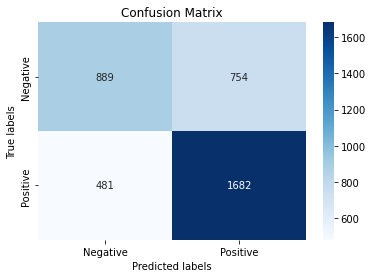

F1-Score of Baseline LR is 0.7314633616003479
AUC of Baseline LR is 0.729575646862282


In [ ]:
clf_baseline = LogisticRegression(random_state=42,solver='liblinear')  # liblinear due to small dataset
clf_baseline.fit(train_set1,y_train.values.ravel())
y_pred = clf_baseline.predict(test_set1)
y_pred_proba = clf_baseline.predict_proba(test_set1)[:, 1]

baseline_f1,baseline_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of Baseline LR is",baseline_f1)
print("AUC of Baseline LR is",baseline_auc)


Now we know a classifier that has f1-score and auc above 0.73 will be useful

#### Simple-Models on feature_sets

In [ ]:
# KNN,DT,LR,NB
def simple_models():
    '''
    Try Simple models on all 4 feature sets and see performance
    '''
    datasets = [(train_set1,test_set1),(train_set2,test_set2),(train_set3,test_set3),(train_set4,test_set4)]
    models = [('DT',DecisionTreeClassifier(random_state=42)),('KNN',KNeighborsClassifier()),('NB',MultinomialNB()),('Linear-SVM',LinearSVC(dual=False,random_state=42))]
    result = []  # store tuple of scores for each combination of models and datasets

     # first all(4) models on set-1 then next all on set-2 and so on..
    for idx,(train,test) in enumerate(datasets):
        for name,model in models:
            # since linear-svc has no predict_proba, we'll use calibrated classifier(platt-scaling as dataset size is small) for that
            if name=='Linear-SVM':
                clf = CalibratedClassifierCV(model) 
                clf.fit(train,y_train.values.ravel())
                y_pred_proba = clf.predict_proba(test)[:, 1]

            model.fit(train,y_train.values.ravel())
            y_pred = model.predict(test)
            if name!='Linear-SVM':
                y_pred_proba = model.predict_proba(test)[:, 1]

            print("Vanilla {} on Set-{}".format(name,idx+1))
            f1,auc = calculate_metrics(y_test,y_pred,y_pred_proba)
            result.append((name,f1,auc)) 
        print('='*130)

    return result 

Vanilla DT on Set-1


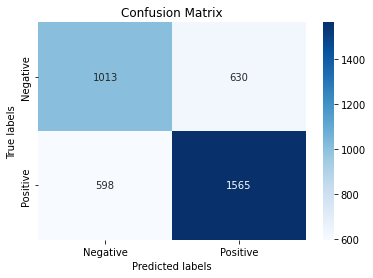

Vanilla KNN on Set-1


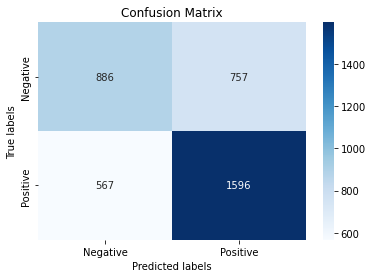

Vanilla NB on Set-1


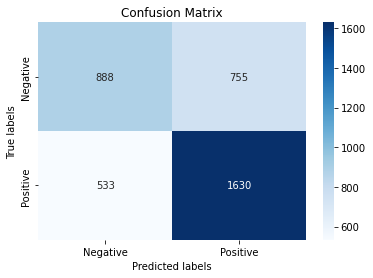

Vanilla Linear-SVM on Set-1


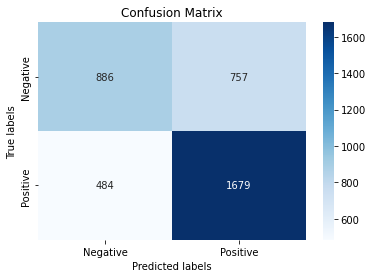

Vanilla DT on Set-2


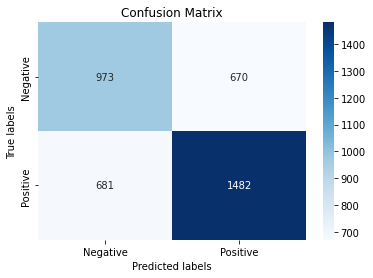

Vanilla KNN on Set-2


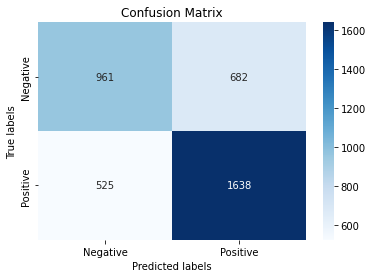

Vanilla NB on Set-2


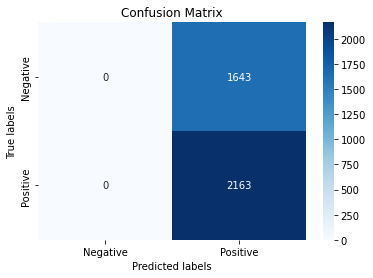

Vanilla Linear-SVM on Set-2


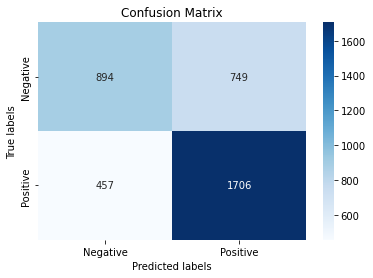

Vanilla DT on Set-3


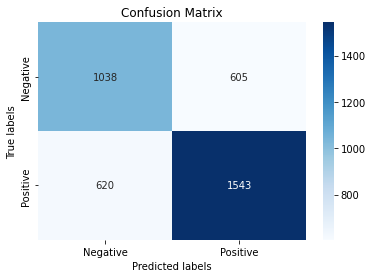

Vanilla KNN on Set-3


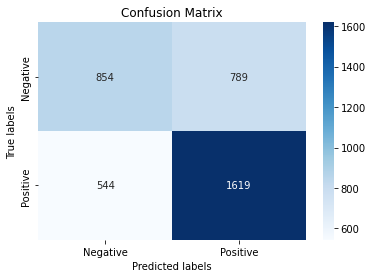

Vanilla NB on Set-3


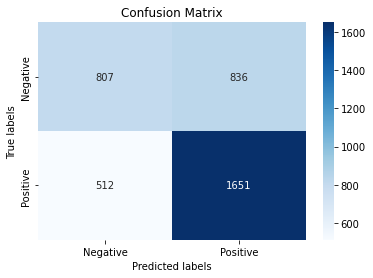

Vanilla Linear-SVM on Set-3


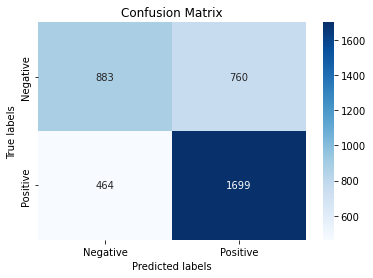

Vanilla DT on Set-4


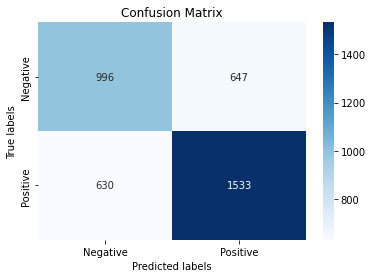

Vanilla KNN on Set-4


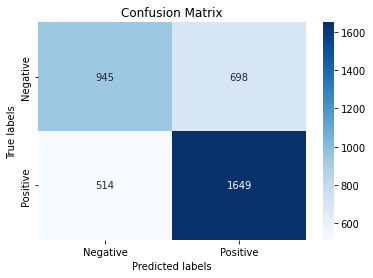

Vanilla NB on Set-4


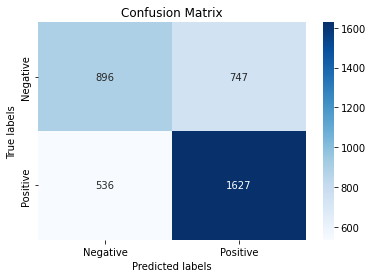

Vanilla Linear-SVM on Set-4


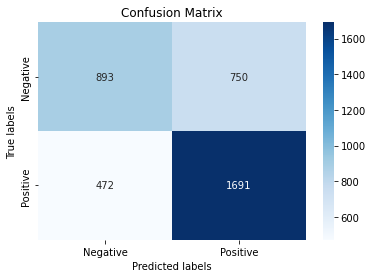

In [ ]:
result = simple_models()

Observations:
* We can see Linear-SVM giving smallest amounts of False-Negatives, which is an important metric in our case.
* Decision Tree is giving the best overall performance keeping both True negatives and True positives high. But in our case study, positives are more important.
* Interestingly,NB is predicting all positives in K-fold dataset(set-2) probably suffering from class imbalance (high priors).

Overall Results

In [ ]:
# making the results table
result_set = pd.DataFrame(result,columns=['Model','F1-score','AUC'])
result_set['Set'] = ['Set-1(OHE)']*4 + ['Set-2(K-Fold)']*4 + ['Set-3(Binary+Label)']*4 + ['Set-4(MIX)']*4
result_set = result_set[['Set','Model', 'F1-score', 'AUC']]   # rearranging cols

# coloring the df
# Reference :- https://stackoverflow.com/a/43601040
def func(row):
    return ['background-color: green' if row.Model=='Linear-SVM' else '']*4
result_set.style.apply(func,axis=1)

,Set,Model,F1-score,AUC
0,Set-1(OHE),DT,0.718219,0.670160
1,Set-1(OHE),KNN,0.706820,0.697425
2,Set-1(OHE),NB,0.716799,0.702841
3,Set-1(OHE),Linear-SVM,0.730159,0.730157
4,Set-2(K-Fold),DT,0.686906,0.638684
5,Set-2(K-Fold),KNN,0.730761,0.722134
6,Set-2(K-Fold),NB,0.724745,0.585037
7,Set-2(K-Fold),Linear-SVM,0.738848,0.729236
8,Set-3(Binary+Label),DT,0.715843,0.673124
9,Set-3(Binary+Label),KNN,0.708379,0.683971


Observations:
* Linear-SVM is the winner among simple models with highest F1-Scores on all sets. AUC is also reasonable. It's performance is best on Set-2 (K-fold data)
* DT is performing best on OHE data.
* KNN is performing best on Set-4 (Mixed encodings) 
* NB performance is mediocre overall

#### Tuning Linear-SVM
Our best simple model was Linear-SVM. Properly Hyper-param tuned Linear-SVM will serve as baseline for our advanced models.

The best paramsa and best score {'C': 0.0001} 0.7469125457417023


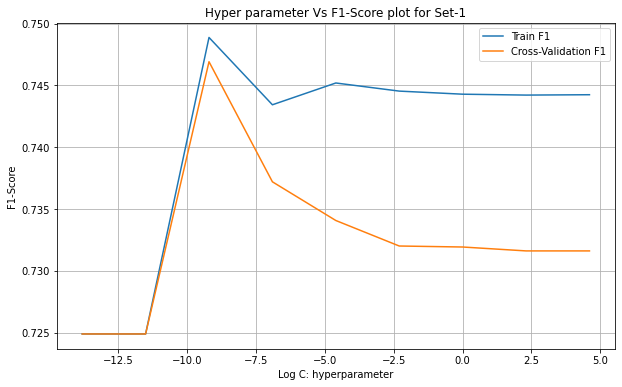


The best paramsa and best score {'C': 0.01} 0.7351629681802521


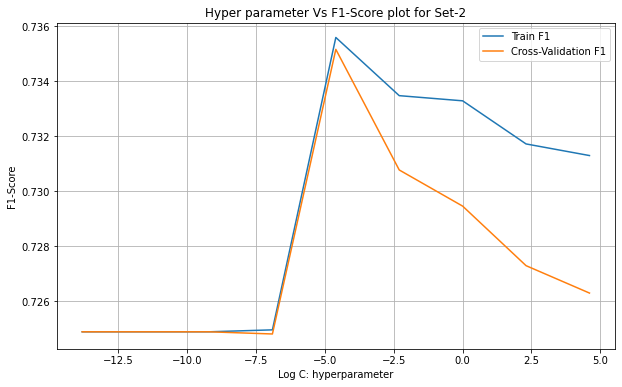


The best paramsa and best score {'C': 0.0001} 0.7403076694430538


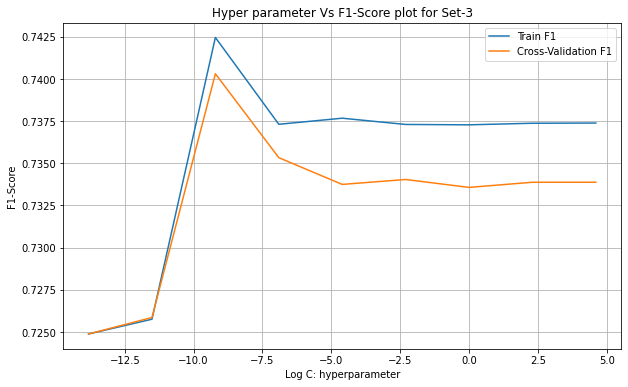


The best paramsa and best score {'C': 0.0001} 0.7412594378773212


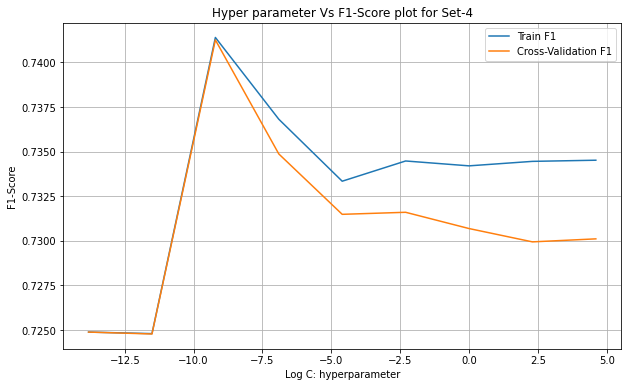

In [ ]:
def tune_lr_svm():

    ''' TUNE Linear-SVM on all datasets '''

    datasets = [(train_set1,test_set1),(train_set2,test_set2),(train_set3,test_set3),(train_set4,test_set4)]
    for idx,(train,test) in enumerate(datasets):
        lr_svm = LinearSVC(dual=False,random_state=42)
        parameters = {'C' : [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]}

        final_clf = GridSearchCV(param_grid=parameters,estimator=lr_svm,scoring='f1',n_jobs=-1,cv=5,return_train_score=True)

        final_clf.fit(train,y_train.values.ravel())
        print("The best paramsa and best score",final_clf.best_params_,final_clf.best_score_)

        results = pd.DataFrame.from_dict(final_clf.cv_results_)
        results = results.sort_values(by=['param_C'])
        train_f1= results['mean_train_score']
        cv_f1 = results['mean_test_score'] 
        c = np.log(results['param_C'].astype(float))

        plt.figure(figsize=(10,6))
        plt.plot(c, train_f1, label='Train F1')
        plt.plot(c, cv_f1, label='Cross-Validation F1')

        plt.legend()
        plt.xlabel("Log C: hyperparameter")
        plt.ylabel("F1-Score")
        plt.title("Hyper parameter Vs F1-Score plot for Set-{}".format(idx+1))
        plt.grid()
        plt.show()
        print()

tune_lr_svm()

Observations on CV data
* Gets highest F1 on Set-1(OHE) and second highest(very close) on Set-4(MIX) datasets.
* Highest F1 is 0.747 on OHE dataset.
* It's pretty comparable with the performance of our baseline Logistic Regression as both are linear models with only a change in loss. OHE dataset is also very high-dim which gives an upper hand to linear models.

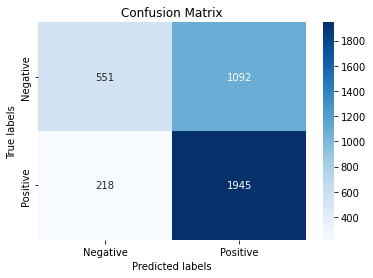

F1-Score of LR-SVM is 0.7480769230769232
AUC of LR-SVM is 0.7090880517214065


In [ ]:
best_simple_model = LinearSVC(dual=False,random_state=42,C=0.0001)
best_simple_model.fit(train_set1,y_train.values.ravel())
y_pred = best_simple_model.predict(test_set1)
# for predict_proba
clf = CalibratedClassifierCV(best_simple_model) 
clf.fit(train_set1,y_train.values.ravel())
y_pred_proba = clf.predict_proba(test_set1)[:, 1]

best_simple_model_f1,best_simple_model_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of LR-SVM is",best_simple_model_f1)
print("AUC of LR-SVM is",best_simple_model_auc)

Observations on test data
* We can clearly see High-Recall but lower precision
* The baseline for our advanced models will be approximately `F1-Score >= 0.75`

#### Advanced Models
1) Random-Forest

In [ ]:
params = {
    'n_estimators':[100,200,300],
    'criterion':['gini','entropy'],
    'min_samples_split':[5,10,25],
    'max_samples':[0.3,0.5,0.7]
}

datasets = [(train_set2,test_set2),(train_set3,test_set3),(train_set4,test_set4)]  # not taking OHE encoded dataset as due to high-dim it'll take a huge amount of time
result_set = []  # to store full randomized-search results from each dataset 
for idx,(train,test) in enumerate(datasets):
    rf = RandomForestClassifier(random_state=42,n_jobs=-1)
    final_clf = RandomizedSearchCV(param_distributions=params,estimator=rf,scoring='f1',cv=5,return_train_score=True)

    final_clf.fit(train,y_train.values.ravel())
    print("The best params and best score",final_clf.best_params_,final_clf.best_score_)

    results = pd.DataFrame.from_dict(final_clf.cv_results_)
    result_set.append(results)
    print('='*130)

The best params and best score {'n_estimators': 300, 'min_samples_split': 5, 'max_samples': 0.3, 'criterion': 'gini'} 0.7668906201844706
The best params and best score {'n_estimators': 300, 'min_samples_split': 10, 'max_samples': 0.5, 'criterion': 'entropy'} 0.7834102795680594
The best params and best score {'n_estimators': 200, 'min_samples_split': 5, 'max_samples': 0.7, 'criterion': 'gini'} 0.7766363642738711


In [ ]:
final_result_rf = result_set[1][['param_n_estimators',	'param_min_samples_split',	'param_max_samples',
                                 'param_criterion','mean_test_score','mean_train_score']]

max_test_score = final_result_rf.mean_test_score.max()
def func(row):
    return ['background-color: green' if row.mean_test_score==final_result_rf.mean_test_score.max() else '']*6

final_result_rf.style.apply(func,axis=1)


,param_n_estimators,param_min_samples_split,param_max_samples,param_criterion,mean_test_score,mean_train_score
0,300,25,0.700000,entropy,0.777285,0.837446
1,300,25,0.500000,entropy,0.773448,0.824135
2,100,25,0.700000,gini,0.773167,0.833352
3,200,10,0.500000,gini,0.781249,0.882988
4,300,10,0.300000,gini,0.778411,0.852444
5,300,25,0.300000,entropy,0.771206,0.807687
6,200,5,0.300000,gini,0.779770,0.894274
7,300,10,0.500000,entropy,0.783410,0.887020
8,100,10,0.300000,entropy,0.775308,0.850639
9,300,10,0.300000,entropy,0.778575,0.853989


Observations on CV data    
* Random Forest performed best on Set-3 (Binary encoding + Label encoding) dataset giving a **F1 Score > 0.78** which is the best by far.

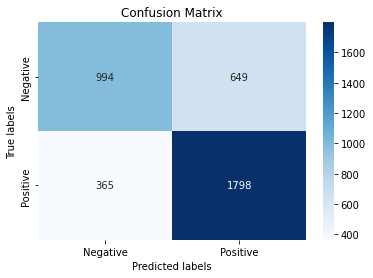

F1-Score of RF is 0.7800433839479393
AUC of RF is 0.802791736978549


In [ ]:
params = {'n_estimators': 300, 'min_samples_split': 10, 'max_samples': 0.5, 'criterion': 'entropy','random_state':42,'n_jobs' : -1}
final_rf = RandomForestClassifier(**params)
final_rf.fit(train_set3,y_train.values.ravel())
y_pred = final_rf.predict(test_set3)

y_pred_proba = final_rf.predict_proba(test_set3)[:, 1]

final_rf_f1,final_rf_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of RF is",final_rf_f1)
print("AUC of RF is",final_rf_auc)

Observation on test data    
* We can see in case of Random-Forest both precision and recall seem to be higher.
* FP is much lesser as compared to Linear-SVM whereas FN is slightly higher. 
* Gives the highest F1-Score and AUC till now which is 0.78 and 0.80 respectively.

2) Dual RBF-Kernelized SVM

Hyper-parameter tuning of `gamma` in Dual kernelized SVM didn't yield any reasonable result and was causing very severe overfitting on small changes. So we'll go with tuning of 'C' and 'kernel' only.

In [ ]:
params = {
    'C' : [1e-4,1e-3,1e-2,1e-1,1,10,100],
    'kernel':['poly','rbf','linear','sigmoid']
}

datasets = [(train_set1,test_set1),(train_set2,test_set2),(train_set3,test_set3),(train_set4,test_set4)] 
result_set2 = []
for idx,(train,test) in enumerate(datasets):
    svm = SVC(random_state=42)
    final_clf = RandomizedSearchCV(param_distributions=params,estimator=svm,scoring='f1',cv=5,n_jobs=-1,return_train_score=True,n_iter=5)

    final_clf.fit(train,y_train.values.ravel())
    print("The best params and best score for Set-{}".format(idx+1),final_clf.best_params_,final_clf.best_score_)

    results = pd.DataFrame.from_dict(final_clf.cv_results_)
    result_set2.append(results)
    print('='*130)

The best params and best score for Set-1 {'kernel': 'rbf', 'C': 1} 0.7886694937223612
The best params and best score for Set-2 {'kernel': 'rbf', 'C': 100} 0.7519448874255658
The best params and best score for Set-3 {'kernel': 'sigmoid', 'C': 0.0001} 0.7248832750421842
The best params and best score for Set-4 {'kernel': 'rbf', 'C': 1} 0.7681286072828847


In [ ]:

final_result_svm = result_set2[0][['param_kernel','param_C','mean_test_score','mean_train_score']]

max_test_score = final_result_svm.mean_test_score.max()
def func(row):
    return ['background-color: green' if row.mean_test_score==final_result_svm.mean_test_score.max() else '']*4

final_result_svm.style.apply(func,axis=1)

,param_kernel,param_C,mean_test_score,mean_train_score
0,rbf,1,0.788669,0.862589
1,linear,0.000100,0.724883,0.724883
2,linear,0.010000,0.734904,0.742467
3,linear,0.100000,0.732874,0.745788
4,sigmoid,0.001000,0.724883,0.724883


Observations on CV data:
* It performs best on Set-1 OHE data.
* We can clearly see `RBF-SVM` has the highest F1-Score till now which is **0.7886** and RF's was **0.78** and it also has less overfitting on train data as compared to RF.

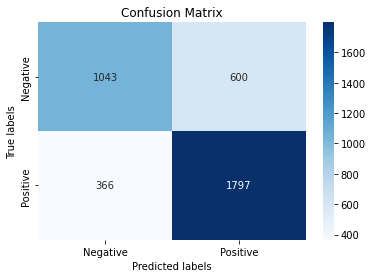

F1-Score of Dual-SVM is 0.7881578947368421
AUC of Dual-SVM is 0.8081406457128113


In [ ]:
params = {'C':1,'random_state':42,'kernel':'rbf','probability':True}
final_svm = SVC(**params).fit(train_set1,y_train.values.ravel())
y_pred = final_svm.predict(test_set1)

y_pred_proba = final_svm.predict_proba(test_set1)[:, 1]

final_svm_f1,final_svm_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of Dual-SVM is",final_svm_f1)
print("AUC of Dual-SVM is",final_svm_auc)

Observations on Test data
* F1-Score of RBF-SVM on test-data (\~ 0.788) is the best one till now.
* It is performing well on negative class as well.

XGBoost

In [ ]:
params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [1,2,3,4,5,6],
    'learning_rate':[0.001,0.01,0.1,1,10],
    'subsample':[0.3,0.5,0.7],
    'colsample_bytree':[0.3,0.5,0.7],
    'reg_alpha ':[0.05,0.1,0.3,1,5],
    'gamma':[0,1,5]
}

# XGBoost does not support columns with names that include chars like '[, ] or <'.

datasets = [(train_set2,test_set2),(train_set3,test_set3),(train_set4,test_set4)]  # not taking OHE encoded dataset as it'll take a huge amount of time due to high dim

result_set = []
for idx,(train,test) in enumerate(datasets):
    xgb = xgboost.XGBClassifier(random_state=42,n_jobs=-1)
    final_clf = RandomizedSearchCV(param_distributions=params,estimator=xgb,scoring='f1',cv=3,return_train_score=True,n_iter=100)

    final_clf.fit(train,y_train.values.ravel())
    print("The best params and best score on Set-{}".format(idx+2),final_clf.best_params_,final_clf.best_score_)

    results = pd.DataFrame.from_dict(final_clf.cv_results_)
    result_set.append(results)
    print('='*130)

The best params and best score on Set-2 {'subsample': 0.7, 'reg_alpha ': 0.3, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.001, 'gamma': 1, 'colsample_bytree': 0.5} 0.7709198573624523
The best params and best score on Set-3 {'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7} 0.787153889915051
The best params and best score on Set-4 {'subsample': 0.5, 'reg_alpha ': 1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.5} 0.7754516052080214


In [ ]:
final_result_xgb = result_set[1][['params','mean_test_score','mean_train_score']]

max_test_score = final_result_xgb.mean_test_score.max()
def func(row):
    return ['background-color: green' if row.mean_test_score==final_result_xgb.mean_test_score.max() else '']*3

final_result_xgb.style.apply(func,axis=1)

,params,mean_test_score,mean_train_score
0,"{'subsample': 0.3, 'reg_alpha ': 1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}",0.765632,0.785425
1,"{'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 10, 'gamma': 0, 'colsample_bytree': 0.7}",0.656014,0.664453
2,"{'subsample': 0.5, 'reg_alpha ': 0.1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 1, 'gamma': 5, 'colsample_bytree': 0.7}",0.730135,0.910846
3,"{'subsample': 0.3, 'reg_alpha ': 0.3, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.5}",0.723558,0.722012
4,"{'subsample': 0.3, 'reg_alpha ': 0.1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.7}",0.778221,0.818541
5,"{'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.001, 'gamma': 5, 'colsample_bytree': 0.7}",0.719341,0.721029
6,"{'subsample': 0.5, 'reg_alpha ': 5, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.5}",0.752058,0.755505
7,"{'subsample': 0.5, 'reg_alpha ': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 10, 'gamma': 1, 'colsample_bytree': 0.7}",0.419501,0.418050
8,"{'subsample': 0.3, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 10, 'gamma': 0, 'colsample_bytree': 0.3}",0.483269,0.483249
9,"{'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 1, 'learning_rate': 1, 'gamma': 0, 'colsample_bytree': 0.3}",0.729472,0.742419


Observations on CV data
* Performs best on Set-3 (Binary+label encoding dataset) with F1-Score of \~ 0.78.



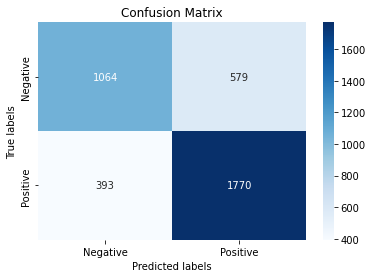

F1-Score of XGBoost is 0.7845744680851062
AUC of XGBoost is 0.8111633180061169


In [ ]:
params = {'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7,'random_state':42,'n_jobs':-1}
final_xgb = xgboost.XGBClassifier(**params).fit(train_set3,y_train.values.ravel())
y_pred = final_xgb.predict(test_set3)

y_pred_proba = final_xgb.predict_proba(test_set3)[:, 1]

final_xgb_f1,final_xgb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of XGBoost is",final_xgb_f1)
print("AUC of XGBoost is",final_xgb_auc)

Observations on Test-data
* F1-SCORE is 0.784. This is the second best score after Dual-SVM.
* XGBoost gave the highest AUC of 0.81.

`Note:-` We will take Dual-SVM and XGBoost from here as they are our top 2 models. We will compare their performance with CATBOOST and choose the final one. We will also try Relief-F on XGBoost for any performance improvement.

#### Relief-F feature selection for XGBoost

In [6]:
def feature_select_with_relief(train,test,n_features=30,neighbors=5):

    ''' Feature selection with Relief-F algortihm '''
    # Reference :- https://epistasislab.github.io/scikit-rebate/using/

    # It's important to send values as arrays and not dataframes as input is expected in sklearn.datasets format
    columns = train.columns
    train = train.values
    test = test.values

    fs = ReliefF(n_features_to_select=n_features, n_neighbors=neighbors)
    fs.fit_transform(train, y_train.values.ravel())
    fs.transform(test)
    best_features_indices = fs.top_features_[:n_features]
    return columns[best_features_indices]

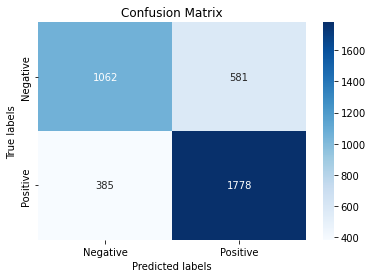

F1-Score of XGBoost on test data is 0.7863777089783283
AUC of XGBoost on test data is 0.807458279271621


In [ ]:

# feature selection with relief-F
feature_selected_cols = feature_select_with_relief(train_set3,test_set3)
X_train_xgb = train_set3[feature_selected_cols]
X_test_xgb = test_set3[feature_selected_cols]

# using previously tuned best hyper-params
params = {'subsample': 0.7, 'reg_alpha ': 0.05, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7,'random_state':42,'n_jobs':-1}

xgb = xgboost.XGBClassifier(**params)

xgb.fit(X_train_xgb,y_train.values.ravel())

y_pred = xgb.predict(X_test_xgb)
y_pred_proba = xgb.predict_proba(X_test_xgb)[:, 1]

xgb_f1,xgb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of XGBoost on test data is",xgb_f1)
print("AUC of XGBoost on test data is",xgb_auc)

Observations:   
As we can see from above results, Relief-F feature selection gives us small improvement in performance but dual-SVM still remains the best one so far.

#### Implement CATBoost and compare

Common-value tuned CatBoost 

0:	learn: 0.6712839	total: 17.7ms	remaining: 17.7s
1:	learn: 0.7541081	total: 32.7ms	remaining: 16.3s
2:	learn: 0.7582316	total: 46.9ms	remaining: 15.6s
3:	learn: 0.7582991	total: 67.1ms	remaining: 16.7s
4:	learn: 0.7577599	total: 82.4ms	remaining: 16.4s
5:	learn: 0.7533669	total: 96ms	remaining: 15.9s
6:	learn: 0.7545842	total: 109ms	remaining: 15.4s
7:	learn: 0.7561393	total: 121ms	remaining: 15.1s
8:	learn: 0.7543701	total: 134ms	remaining: 14.8s
9:	learn: 0.7562156	total: 147ms	remaining: 14.5s
10:	learn: 0.7589468	total: 158ms	remaining: 14.2s
11:	learn: 0.7616412	total: 175ms	remaining: 14.4s
12:	learn: 0.7621304	total: 187ms	remaining: 14.2s
13:	learn: 0.7636453	total: 199ms	remaining: 14s
14:	learn: 0.7635444	total: 210ms	remaining: 13.8s
15:	learn: 0.7652812	total: 225ms	remaining: 13.8s
16:	learn: 0.7648545	total: 235ms	remaining: 13.6s
17:	learn: 0.7649214	total: 249ms	remaining: 13.6s
18:	learn: 0.7672147	total: 261ms	remaining: 13.5s
19:	learn: 0.7690430	total: 276ms	remai

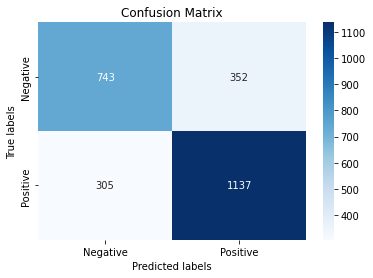

F1-Score of Vanilla CATBoost is 0.7758444216990787
AUC of Vanilla CATBoost is 0.8089535082552772


In [52]:
# catboost

# making all attributes categorical and no encoding is required
X_train_cb = X_train.astype(str)
X_test_cb = X_test.astype(str)
cat_features = X_train_cb.columns.values

cb = CatBoostClassifier(max_depth=3,
                        cat_features=cat_features,
                        learning_rate=0.5,
                        n_estimators=1000,
                        subsample=0.7,
                        random_state=42,
                        early_stopping_rounds=2,
                        one_hot_max_size=3,
                        loss_function='Logloss',
                        eval_metric='F1',
                        custom_metric='F1',
                        reg_lambda=5,
                        colsample_bylevel=0.7,
                        min_child_samples=15)
cb.fit(X_train_cb,y_train.values.ravel())
y_pred = cb.predict(X_test_cb)
y_pred_proba = cb.predict_proba(X_test_cb)[:, 1]

cb_f1,cb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of Vanilla CATBoost is",cb_f1)
print("AUC of Vanilla CATBoost is",cb_auc)

Observations  
* Manually tuned CATBoost performance is pretty comparable to XGBoost.    


Randomized-Search on CatBoost

In [53]:
# random search
X_train_cb = X_train.astype(str)
X_test_cb = X_test.astype(str)
cat_features = X_train_cb.columns.values

final_cb = CatBoostClassifier(loss_function='Logloss',cat_features=cat_features,random_state=42,eval_metric='F1',custom_metric='F1',one_hot_max_size=3)

params = {
    'learning_rate': [0.03, 0.1,0.5],
    'depth': [1,2,3,4,6,10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'subsample':[0.3,0.5,0.7],
    'colsample_bylevel':[0.3,0.5,0.7],
    'early_stopping_rounds':[5,7,10],
    'min_child_samples':[5,10,25,50],
    'n_estimators':[150,300,500,1000]
}

# UNFORTUNATELY, realtime plotting of results per hyperparamter-combination of Catboost is not supported in colab 
randomized_search_result = final_cb.randomized_search(param_distributions=params,
                  X=X_train_cb,
                  y=y_train.values.ravel(),
                  cv=5,
                  n_iter=300,
                  partition_random_seed=42,
                  calc_cv_statistics=True,
                  search_by_train_test_split=True,
                  refit=True,
                  shuffle=True,
                  stratified=True,
                  train_size=0.8,
                  verbose=False)

Streaming output truncated to the last 5000 lines.
25:	learn: 0.7984767	test: 0.7803856	best: 0.7803856 (25)	total: 584ms	remaining: 10.6s
26:	learn: 0.8031789	test: 0.7788502	best: 0.7803856 (25)	total: 603ms	remaining: 10.6s
27:	learn: 0.8042514	test: 0.7795044	best: 0.7803856 (25)	total: 619ms	remaining: 10.4s
28:	learn: 0.8045408	test: 0.7795044	best: 0.7803856 (25)	total: 640ms	remaining: 10.4s
29:	learn: 0.8061119	test: 0.7779182	best: 0.7803856 (25)	total: 658ms	remaining: 10.3s
30:	learn: 0.8080140	test: 0.7771236	best: 0.7803856 (25)	total: 680ms	remaining: 10.3s
31:	learn: 0.8095090	test: 0.7778244	best: 0.7803856 (25)	total: 699ms	remaining: 10.2s
32:	learn: 0.8112798	test: 0.7784784	best: 0.7803856 (25)	total: 735ms	remaining: 10.4s
33:	learn: 0.8126616	test: 0.7773109	best: 0.7803856 (25)	total: 753ms	remaining: 10.3s
34:	learn: 0.8124159	test: 0.7788502	best: 0.7803856 (25)	total: 774ms	remaining: 10.3s
35:	learn: 0.8134189	test: 0.7784784	best: 0.7803856 (25)	total: 795m

In [54]:
results = pd.DataFrame.from_dict(randomized_search_result['cv_results'])
best_params = randomized_search_result['params']
print("The train F1-Score is {}".format(results['train-F1-mean'].max()))
print("The best hyper-parameters are",best_params)

The train F1-Score is 0.8584974913611866
The best hyper-parameters are {'min_data_in_leaf': 5, 'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 9, 'iterations': 300, 'subsample': 0.7, 'rsm': 0.7, 'learning_rate': 0.1}


0:	learn: 0.7531095	total: 97ms	remaining: 29s
1:	learn: 0.7644474	total: 217ms	remaining: 32.4s
2:	learn: 0.7694876	total: 314ms	remaining: 31.1s
3:	learn: 0.7761392	total: 416ms	remaining: 30.8s
4:	learn: 0.7772433	total: 517ms	remaining: 30.5s
5:	learn: 0.7791436	total: 637ms	remaining: 31.2s
6:	learn: 0.7802514	total: 735ms	remaining: 30.8s
7:	learn: 0.7820891	total: 845ms	remaining: 30.9s
8:	learn: 0.7835827	total: 970ms	remaining: 31.4s
9:	learn: 0.7883546	total: 1.09s	remaining: 31.8s
10:	learn: 0.7932869	total: 1.21s	remaining: 31.8s
11:	learn: 0.7930921	total: 1.31s	remaining: 31.5s
12:	learn: 0.7917628	total: 1.44s	remaining: 31.7s
13:	learn: 0.7940667	total: 1.54s	remaining: 31.5s
14:	learn: 0.7971970	total: 1.67s	remaining: 31.7s
15:	learn: 0.8005275	total: 1.79s	remaining: 31.8s
16:	learn: 0.8030003	total: 1.91s	remaining: 31.7s
17:	learn: 0.8056333	total: 2.01s	remaining: 31.5s
18:	learn: 0.8080541	total: 2.13s	remaining: 31.5s
19:	learn: 0.8095631	total: 2.25s	remaining:

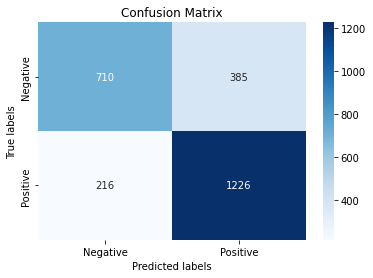

F1-Score of CATBoost is 0.803144448083852
AUC of CATBoost is 0.8357098525006492


In [55]:
cb = CatBoostClassifier(loss_function='Logloss',cat_features=cat_features,random_state=42,eval_metric='F1',custom_metric='F1',one_hot_max_size=3,**best_params)
cb.fit(X_train_cb,y_train.values.ravel())
y_pred = cb.predict(X_test_cb)
y_pred_proba = cb.predict_proba(X_test_cb)[:, 1]

cb_f1,cb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of CATBoost is",cb_f1)
print("AUC of CATBoost is",cb_auc)

Observations
* After doing extensive Hyper-param search(300 combinations) on data with Catboost we got `highest F1-Score ~0.80` on test data.
* It also gives the highest `AUC of ~0.83`

#### Relief-F feature selection for CATBoost

Streaming output truncated to the last 5000 lines.
26:	learn: 0.7715491	test: 0.7639171	best: 0.7645384 (22)	total: 362ms	remaining: 6.35s
27:	learn: 0.7713482	test: 0.7627188	best: 0.7645384 (22)	total: 378ms	remaining: 6.37s
28:	learn: 0.7727364	test: 0.7636215	best: 0.7645384 (22)	total: 390ms	remaining: 6.34s
29:	learn: 0.7730568	test: 0.7593276	best: 0.7645384 (22)	total: 401ms	remaining: 6.29s
Stopped by overfitting detector  (7 iterations wait)

bestTest = 0.7645384303
bestIteration = 22

0:	learn: 0.7187200	test: 0.7009426	best: 0.7009426 (0)	total: 46.4ms	remaining: 23.1s
1:	learn: 0.7593007	test: 0.7364975	best: 0.7364975 (1)	total: 98.7ms	remaining: 24.6s
2:	learn: 0.7796474	test: 0.7439024	best: 0.7439024 (2)	total: 149ms	remaining: 24.7s
3:	learn: 0.7935807	test: 0.7526189	best: 0.7526189 (3)	total: 211ms	remaining: 26.1s
4:	learn: 0.7930724	test: 0.7541247	best: 0.7541247 (4)	total: 221ms	remaining: 21.9s
5:	learn: 0.7947220	test: 0.7543364	best: 0.7543364 (5)	total: 267m

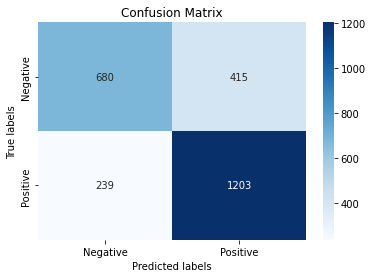

F1-Score of CATBoost is 0.7862745098039216
AUC of CATBoost is 0.8046694405917707


In [27]:

# since releif-f takes encoded data, we encode with the way catboost encodes it internally
enc = ce.cat_boost.CatBoostEncoder(random_state=42,return_df=True)
train = enc.fit_transform(X_train.astype(str),y_train)
test = enc.transform(X_test.astype(str))

# running relief-f
feature_selected_cols = feature_select_with_relief(train,test,n_features=15)
X_train_cb = X_train[feature_selected_cols].astype(str)
X_test_cb = X_test[feature_selected_cols].astype(str)

# PARAMETER - SEARCH
cat_features = X_train_cb.columns.values

final_cb = CatBoostClassifier(loss_function='Logloss',cat_features=cat_features,random_state=42,eval_metric='F1',custom_metric='F1',one_hot_max_size=3)

params = {
    'learning_rate': [0.03, 0.1,0.5],
    'depth': [1,2,3,4,6,10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'subsample':[0.3,0.5,0.7],
    'colsample_bylevel':[0.3,0.5,0.7],
    'early_stopping_rounds':[5,7,10],
    'min_child_samples':[5,10,25,50],
    'n_estimators':[150,300,500,1000]
}

# UNFORTUNATELY, realtime plotting of results per hyperparamter-combination of Catboost is not supported in colab 
randomized_search_result = final_cb.randomized_search(param_distributions=params,
                  X=X_train_cb,
                  y=y_train.values.ravel(),
                  cv=5,
                  n_iter=300,
                  partition_random_seed=42,
                  calc_cv_statistics=True,
                  search_by_train_test_split=True,
                  refit=True,
                  shuffle=True,
                  stratified=True,
                  train_size=0.8,
                  verbose=False)

best_params = randomized_search_result['params']

model = CatBoostClassifier(loss_function='Logloss',random_state=42,eval_metric='F1',custom_metric='F1',one_hot_max_size=3,cat_features = X_train_cb.columns.values,verbose=False,**best_params)
model.fit(X_train_cb,y_train.values.ravel())
y_pred = model.predict(X_test_cb)

y_pred_proba = model.predict_proba(X_test_cb)[:, 1]

cb_f1,cb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of CATBoost is",cb_f1)
print("AUC of CATBoost is",cb_auc)

Observations
* No significant improvement seen as F1-Score reaches upto \~0.786

#### Feature Expansion

In [ ]:
def feature_expansion(train,test,k):
    '''
    We will find cluster labels for our instances and try K-modes algorithm to find clusters since all our data is categorical.
    Kmodes sees how dissimilar my data points are from their centers. Dissimilarity metric can be thought of as Hamming-distance.

    Algo-
    1) kmodes finds cluster_labels according to closest centroids/modes to instances. 
    2) It finds modes(think of finding mode category per attribute) instead of means.
    3) break on convergence
    '''
    kmode = KModes(n_clusters=k, init = "Huang", n_init = 5, verbose=0,n_jobs=-1)
    train_labels = kmode.fit_predict(train)
    test_labels = kmode.predict(test)
    return train_labels,test_labels

100%|██████████| 9/9 [08:37<00:00, 57.54s/it]


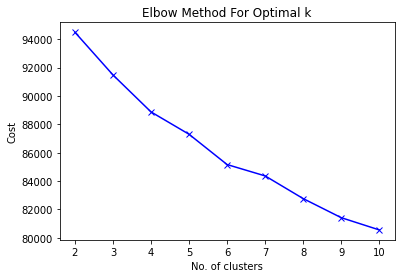

In [ ]:
# Reference :- https://github.com/nicodv/kmodes/blob/master/kmodes/kmodes.py
# https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/#:~:text=KModes%20clustering%20is%20one%20of,similar%20our%20data%20points%20are.

# finding best 'k' using elbow method
cost = [] # sum of dissimilarities of points from thier centroids
cluster_number = []
K = 10
for k in tqdm(range(2,K+1)):
    kmode = KModes(n_clusters=k, init = "Huang", n_init = 5, verbose=0,n_jobs=-1)
    kmode.fit_predict(X_train)
    cost.append(kmode.cost_)
    cluster_number.append(k)
    
plt.plot(cluster_number, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In my opinion there is a sharp decrease till 6 after which decrease slows down comparatively. So we choose k=6

In [ ]:
tr_label,te_label = feature_expansion(X_train,X_test,k=6)  # fetching labels
# assigning a new feature based on cluster labels
X_train_cb['Consumer_Segment'] = tr_label
X_test_cb['Consumer_Segment'] = te_label
X_train_cb = X_train_cb.astype(str)
X_test_cb = X_test_cb.astype(str)

0:	learn: 0.7451812	total: 69.9ms	remaining: 34.9s
1:	learn: 0.7822063	total: 135ms	remaining: 33.6s
2:	learn: 0.7923225	total: 201ms	remaining: 33.2s
3:	learn: 0.7946411	total: 292ms	remaining: 36.2s
4:	learn: 0.7972002	total: 387ms	remaining: 38.3s
5:	learn: 0.8010520	total: 458ms	remaining: 37.7s
6:	learn: 0.8036891	total: 519ms	remaining: 36.6s
7:	learn: 0.8041004	total: 582ms	remaining: 35.8s
8:	learn: 0.8045070	total: 667ms	remaining: 36.4s
9:	learn: 0.8070571	total: 746ms	remaining: 36.5s
10:	learn: 0.8067133	total: 832ms	remaining: 37s
11:	learn: 0.8141626	total: 906ms	remaining: 36.9s
12:	learn: 0.8172404	total: 997ms	remaining: 37.3s
13:	learn: 0.8183938	total: 1.09s	remaining: 37.7s
14:	learn: 0.8201211	total: 1.21s	remaining: 39s
15:	learn: 0.8208802	total: 1.22s	remaining: 36.9s
16:	learn: 0.8203699	total: 1.3s	remaining: 37s
17:	learn: 0.8281308	total: 1.4s	remaining: 37.5s
18:	learn: 0.8308323	total: 1.5s	remaining: 38s
19:	learn: 0.8331778	total: 1.58s	remaining: 38s
20

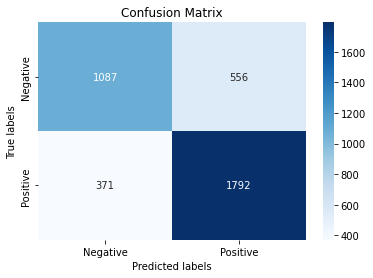

F1-Score of CATBoost is 0.794502327643538
AUC of CATBoost is 0.8234900918985798


In [ ]:
# modelling on catboost

# using previous best hyperparams
params = {'min_data_in_leaf': 50, 'depth': 10, 'od_wait': 10, 'l2_leaf_reg': 3, 'iterations': 500, 'subsample': 0.5, 'rsm': 0.3, 'learning_rate': 0.1}  

cat_features = X_train_cb.columns.values
cb = CatBoostClassifier(loss_function='Logloss',cat_features=cat_features,random_state=42,eval_metric='F1',custom_metric='F1',one_hot_max_size=3,**params)
cb.fit(X_train_cb,y_train.values.ravel())
y_pred = cb.predict(X_test_cb)
y_pred_proba = cb.predict_proba(X_test_cb)[:, 1]

cb_f1,cb_auc = calculate_metrics(y_test,y_pred,y_pred_proba)
print("F1-Score of CATBoost is",cb_f1)
print("AUC of CATBoost is",cb_auc)

Observations 
* Adding this feature decreased the F1-Score hence we will not be going with this approach.
* Even hyper-param tuning did not help.

#### To try Stacking, we should hyperparameter tune simple models as well.

In [ ]:
def simple_models_tuner():
    '''
    Try Simple models on all 4 feature sets and see performance
    '''
    datasets = [('OHE',train_set1,test_set1),('K-FOLD',train_set2,test_set2),('BINARY+LABEL',train_set3,test_set3),('MIX',train_set4,test_set4)]
    models = [('DT',DecisionTreeClassifier(random_state=42)),('KNN',KNeighborsClassifier()),('NB',MultinomialNB(class_prior=[0.5,0.5])),('Log-reg',LogisticRegression(random_state=42))]
    d1 = {'criterion': ['gini', 'entropy'],
          'max_depth': [2, 3, 5, 10, 20],
          'min_samples_leaf': [5, 10, 20, 50, 100]
          }
    d2 = {'n_neighbors':[5,10,15,25,50,70]}
    d3= {'alpha':[1e-3,1e-2,1e-1,1,10,50,100]}
    d4 = {'C' : [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]}
    parameters = [d1,d2,d3,d4]

    for set_name,train,test in datasets:
        print("Dataset",set_name)
        for (name,model),param_grid in zip(models,parameters):
            model = GridSearchCV(param_grid=param_grid,estimator=model,scoring='f1',n_jobs=-1,cv=5,refit=True)
            model.fit(train,y_train.values.ravel())

            y_pred = model.predict(test)
            y_pred_proba = model.predict_proba(test)[:,1]

            f1 = metrics.f1_score(y_test,y_pred)
            auc = metrics.roc_auc_score(y_test,y_pred_proba)
            print("{} on test-data has F1 of {} and AUC of {}".format(name,f1,auc))
            print("params:",model.best_params_)

        print('='*130)


In [ ]:
simple_models_tuner()

Dataset OHE
DT on test-data has F1 of 0.7506607929515418 and AUC of 0.7568632698043141
params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 50}
KNN on test-data has F1 of 0.7563775510204082 and AUC of 0.7503499766025692
params: {'n_neighbors': 25}
NB on test-data has F1 of 0.701625830089306 and AUC of 0.7036150507807257
params: {'alpha': 100}
Log-reg on test-data has F1 of 0.7470019342359767 and AUC of 0.7130556256681211
params: {'C': 0.001}
Dataset K-FOLD
DT on test-data has F1 of 0.7281772953414744 and AUC of 0.7445908038389232
params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100}
KNN on test-data has F1 of 0.7461639631740464 and AUC of 0.7498720387055129
params: {'n_neighbors': 70}
NB on test-data has F1 of 0.5896215726263313 and AUC of 0.5850028800084641
params: {'alpha': 0.001}
Log-reg on test-data has F1 of 0.7428691275167785 and AUC of 0.7245202260447874
params: {'C': 0.1}
Dataset BINARY+LABEL
DT on test-data has F1 of 0.7551573244425922 and

* DT SET 3 --> {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 50}
* KNN SET 1 -->{'n_neighbors': 25}
* NB SET 1 --> {'alpha': 100}
* log-reg SET 1 --> {'C': 0.001}

#### Tabulate ALL results

In [29]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model','Feature-Set','Test_F1','Test_AUC']
x.add_row(['Decision Tree','Set-3',0.750,0.756])
x.add_row(['KNN','Set-1',0.756,0.750])
x.add_row(['MultinomialNB','Set-1',0.701,0.703])
x.add_row(['Logistic Regressor','Set-1',0.747,0.713])
x.add_row(['Linear-SVM','Set-1',0.748,0.709])
x.add_row(['Random Forest','Set-3',0.780,0.80])
x.add_row(['RBF-SVM','Set-1',0.788,0.80])
x.add_row(['XGBoost','Set-3',0.784,0.81])
x.add_row(['XGBoost','Set-3 + Relief-F Feature_selection',0.786,0.80])
x.add_row(['CatBoost','Raw-Data / Inbuilt Ordered Encoding',0.80,0.83])
x.add_row(['CATBoost','Inbuilt Ordered Encoding + Relief-F Feature_selection',0.786,0.80])
print(x)
print("\nAdditional-Observations\nFeature Expansion and K-fold Encoding did not work at all.\nAlso, Relief-F with XGBoost/Catboost did not show any significant improvement.")

+--------------------+-------------------------------------------------------+---------+----------+
|       Model        |                      Feature-Set                      | Test_F1 | Test_AUC |
+--------------------+-------------------------------------------------------+---------+----------+
|   Decision Tree    |                         Set-3                         |   0.75  |  0.756   |
|        KNN         |                         Set-1                         |  0.756  |   0.75   |
|   MultinomialNB    |                         Set-1                         |  0.701  |  0.703   |
| Logistic Regressor |                         Set-1                         |  0.747  |  0.713   |
|     Linear-SVM     |                         Set-1                         |  0.748  |  0.709   |
|   Random Forest    |                         Set-3                         |   0.78  |   0.8    |
|      RBF-SVM       |                         Set-1                         |  0.788  |   0.8    |


### END 
*(Stacking in 'Modelling_Experimentations_continued.ipynb' notebook)*